In [233]:
# !pip install pandas --quiet
# !pip install openpyxl --quiet
# !pip install sklearn --quiet
# !pip install matplotlib --quiet
# !pip install seaborn --quiet
# !pip install xgboost --quiet
# !pip install statsmodels -- quiet


In [6]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import classification_report,confusion_matrix
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
data = pd.read_excel('health_dataset.xlsx')

## 1. Preliminary Analysis

In [236]:
print(data.shape)
print(data.columns)

(303, 14)
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')


Missing Values

In [237]:
data.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Duplicates

In [238]:
print('Before dropping duplicates')
print(f'Number of duplicates: {data.shape[0] - data.drop_duplicates().shape[0]}')
data.drop_duplicates(inplace=True)
print('')
print('After dropping duplicates')
print(f'Number of duplicates: {data.shape[0] - data.drop_duplicates().shape[0]}')

Before dropping duplicates
Number of duplicates: 1

After dropping duplicates
Number of duplicates: 0


Split the dataset into train and test

In [8]:
train,test,trainLab,testLab = train_test_split(data[[col for col in data.columns if col != 'target']],data['target'],test_size=0.2,random_state=314)

## 2. Prepare a Report About the Data

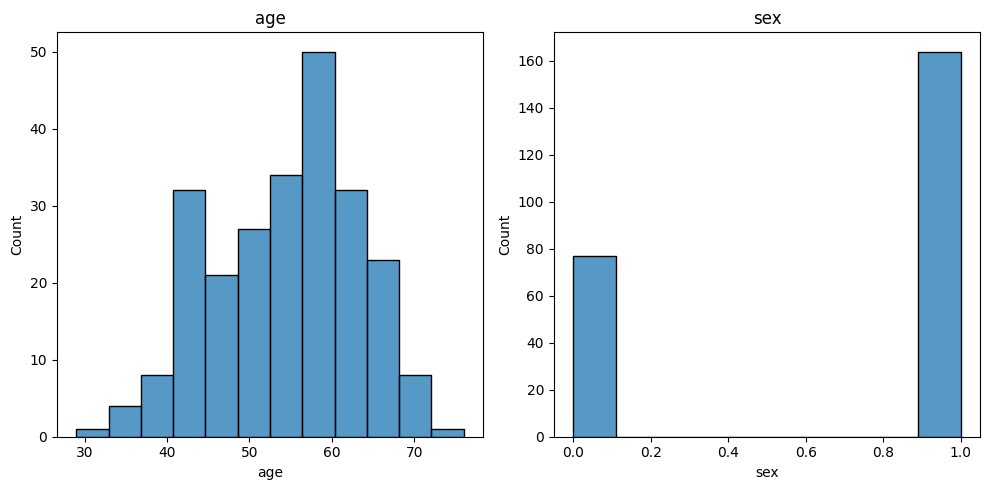

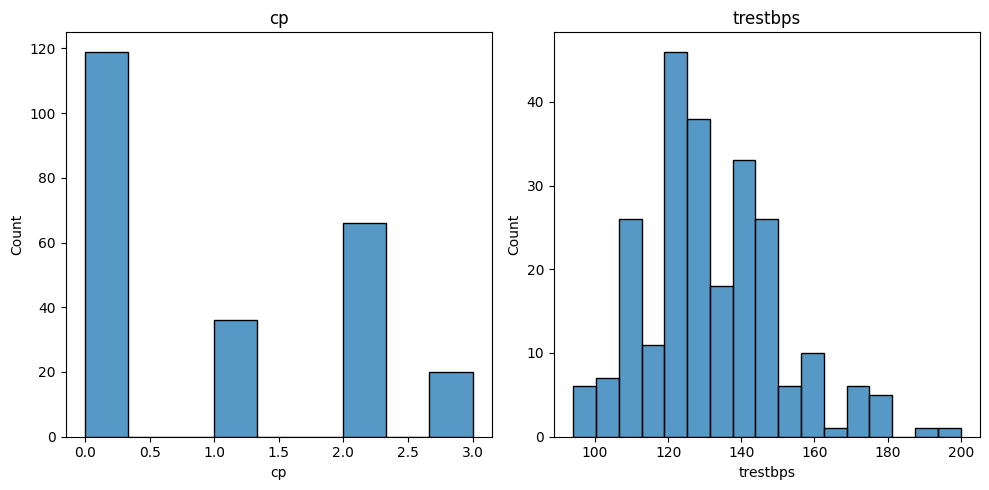

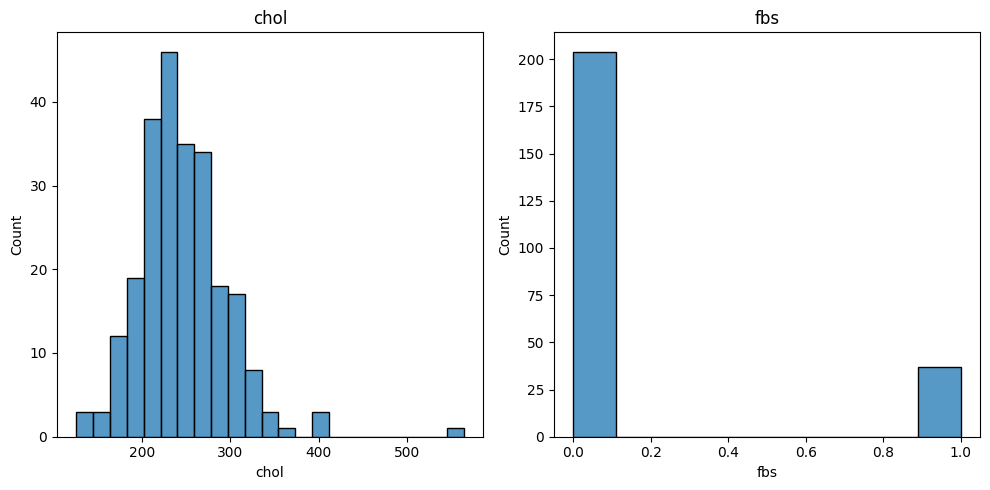

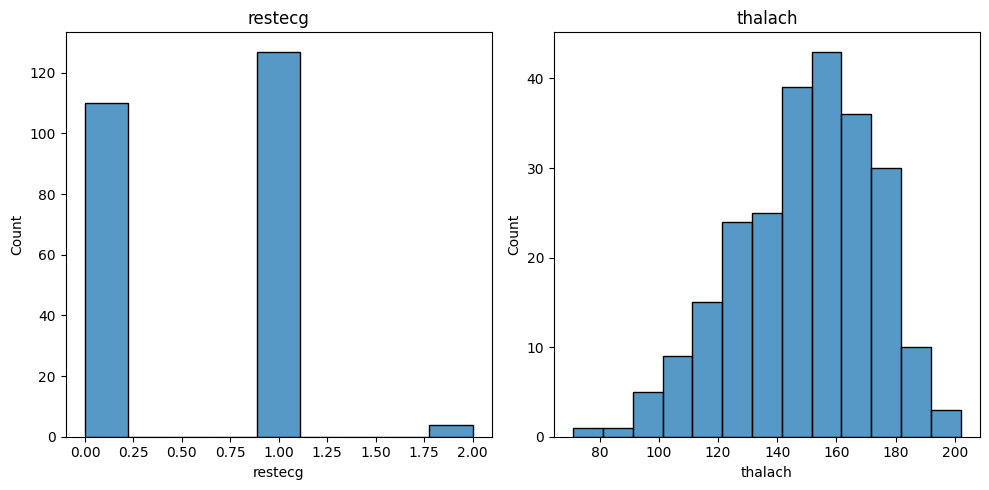

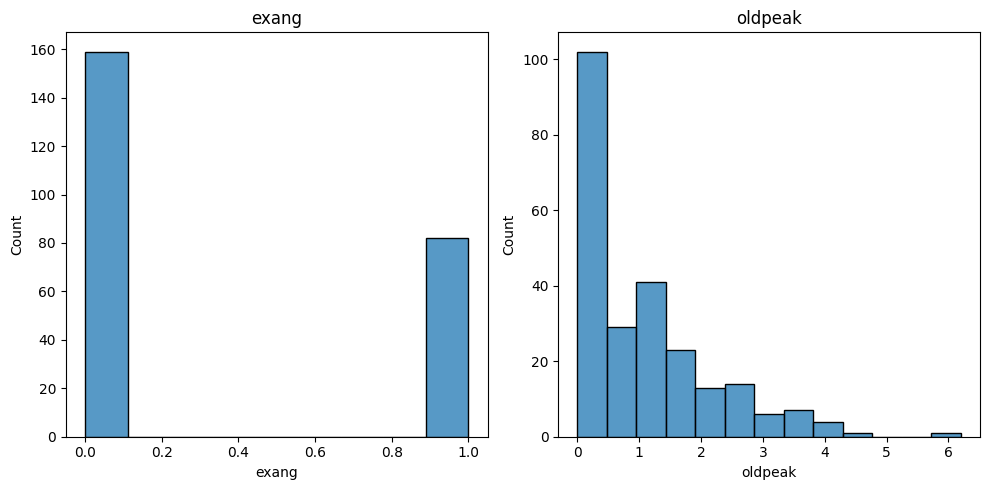

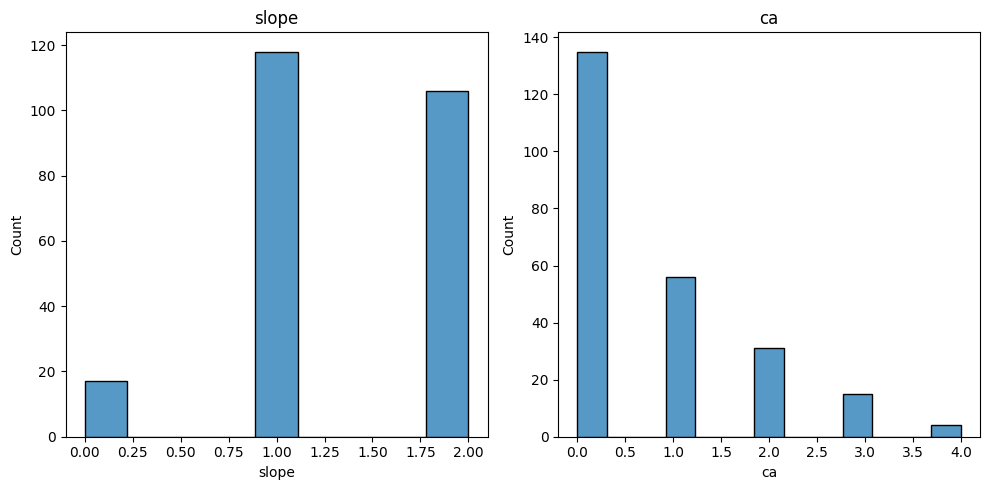

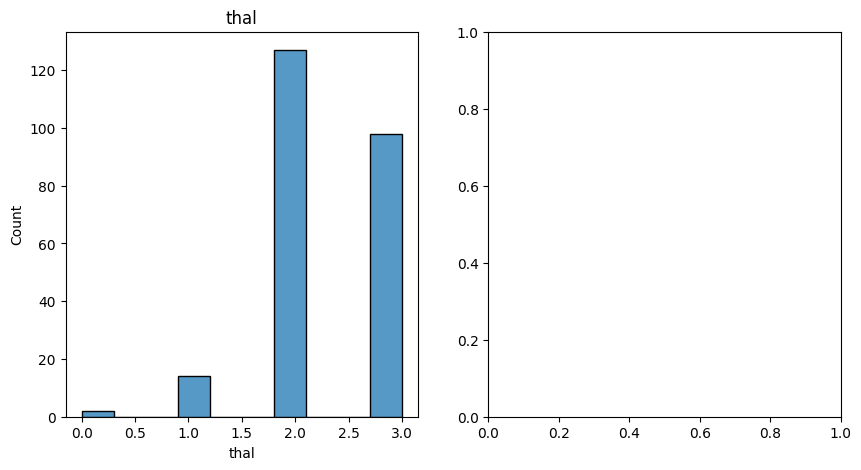

In [240]:
## Show the distribution of each variable

cols = train.columns
for i in range(0,len(cols),2):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.title(cols[i])
    sns.histplot(train[cols[i]])
    try:
        plt.subplot(122)
        plt.title(cols[i+1])
        sns.histplot(train[cols[i+1]])
        plt.tight_layout()
        plt.show()
    except:
        pass
    plt.show()


## 3. Modeling

Look at correlations with target variable using heatmap

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,label
label,-0.206833,-0.242584,0.432785,-0.110553,-0.094935,0.000949,0.145719,0.423660,-0.441631,-0.405788,0.348367,-0.362754,-0.375206,1.000000
cp,-0.010004,0.003004,1.000000,0.036484,-0.087492,0.135127,0.033162,0.268629,-0.407674,-0.169031,0.117825,-0.127170,-0.198126,0.432785
thalach,-0.366109,-0.028000,0.268629,-0.071419,-0.008299,0.018272,-0.000636,1.000000,-0.416027,-0.348956,0.373896,-0.167085,-0.111510,0.423660
slope,-0.180426,-0.011387,0.117825,-0.141210,-0.045022,-0.071797,0.085715,0.373896,-0.258973,-0.609154,1.000000,-0.091056,-0.115893,0.348367
restecg,-0.070325,-0.082034,0.033162,-0.091016,-0.149063,-0.082429,1.000000,-0.000636,-0.047432,-0.067103,0.085715,-0.043860,-0.013715,0.145719
fbs,0.109869,0.036422,0.135127,0.168316,0.011262,1.000000,-0.082429,0.018272,0.026395,-0.026877,-0.071797,0.138801,0.045810,0.000949


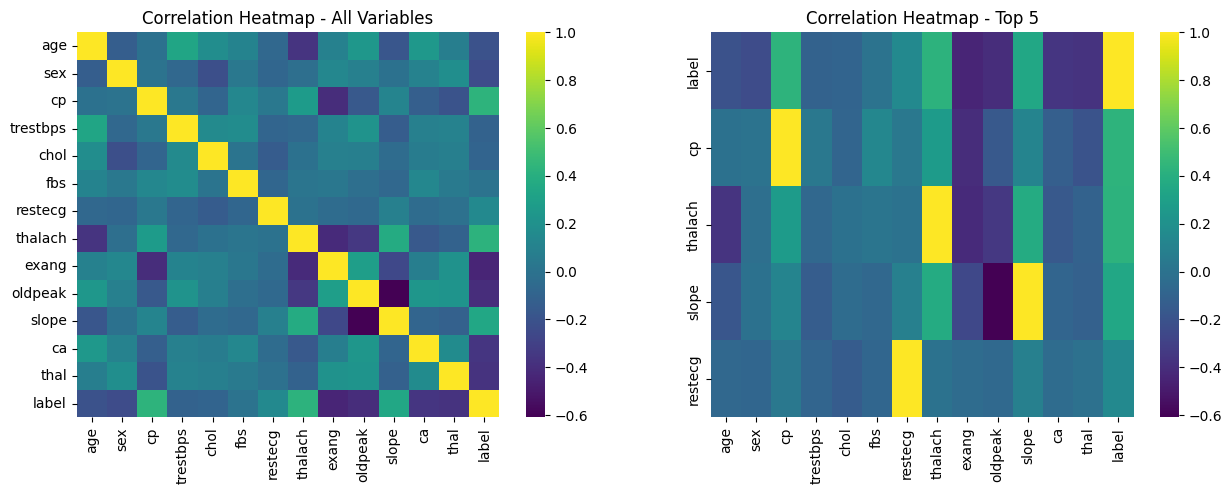

In [52]:
train_dummy = train.copy()
train_dummy['label'] = trainLab
train_dummy = train_dummy[[col for col in train_dummy.columns if 'scaled' not in col]]

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('Correlation Heatmap - All Variables')
sns.heatmap(train_dummy.corr(),cmap='viridis')
plt.subplot(122)
plt.title('Correlation Heatmap - Top 5')
sns.heatmap(train_dummy.corr().nlargest(5,'label'),cmap='viridis')

# print(train_dummy.corr())
train_dummy.corr().nlargest(6,'label')

In [242]:
model = sm.OLS(trainLab,train)
olsres = model.fit()
sum = olsres.summary()

Explore using statsmodels.api.OLS() for feature selection based on p-values

In [243]:
sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 target   R-squared (uncentered):                   0.765
Model:                            OLS   Adj. R-squared (uncentered):              0.752
Method:                 Least Squares   F-statistic:                              57.21
Date:                Sat, 08 Oct 2022   Prob (F-statistic):                    3.26e-64
Time:                        12:39:52   Log-Likelihood:                         -91.963
No. Observations:                 241   AIC:                                      209.9
Df Residuals:                     228   BIC:                                      255.2
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0030      0.003      1.081      0.281      -0.002       0.008
sex           -0.1595      0.053     -2.993      0.003      -0.264      -0.055
cp             0.1107      0.025      4.350      0.000       0.061       0.161
trestbps      -0.0004      0.001     -0.279      0.780      -0.003       0.002
chol          -0.0001      0.000     -0.214      0.831      -0.001       0.001
fbs           -0.0148      0.068     -0.217      0.829      -0.149       0.120
restecg        0.0529      0.045      1.176      0.241      -0.036       0.142
thalach        0.0046      0.001      4.618      0.000       0.003       0.007
exang         -0.1390      0.058     -2.407      0.017      -0.253      -0.025
oldpeak       -0.0424      0.028     -1.513      0.132      -0.098       0.013
slope          0.1197      0.051      2.368      0.019       0.020       0.219
ca            -0.0994      0.026     -3.865      0.000      -0.150      -0.049
thal          -0.1148      0.040     -2.867      0.005      -0.194      -0.036
==============================================================================
Omnibus:                        4.148   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.126   Jarque-Bera (JB):                4.145
Skew:                          -0.319   Prob(JB):                        0.126
Kurtosis:                       2.930   Cond. No.                         959.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Make dictionary with type of each variable (numerical/categorical)

In [9]:
train[[col for col in train.columns if 'scaled' not in col]]
var_type = {'num':['age','trestbps','chol','thalach']}
var_type['cat'] = [col for col in train.columns if col not in var_type['num']]

## Pipeline creation
<ul style="list-style:none">
    <li>
    1. Impute Missing Values // Scale/Encode Variables
    </li>
    <li>
    2. Apply Num/Cat Pipeline to Numerical/Categorical Variables
    </li>
    <li>
    3. Apply Classifier (Grid Search)
    </li>

In [32]:
## 1.
num_pipeline = Pipeline([('si',SimpleImputer(strategy='median')),('std',StandardScaler())])
cat_pipeline = Pipeline([('si',SimpleImputer(strategy='most_frequent')),('ohe',OneHotEncoder(handle_unknown='ignore'))])

In [25]:
## 2.
preprocessing_pipeline = ColumnTransformer([('num',num_pipeline,var_type['num']),('cat',cat_pipeline,var_type['cat'])])

See params from logistic regression

In [37]:
help(LogisticRegression)

Help on class LogisticRegression in module sklearn.linear_model._logistic:

class LogisticRegression(sklearn.linear_model._base.LinearClassifierMixin, sklearn.linear_model._base.SparseCoefMixin, sklearn.base.BaseEstimator)
 |  LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
 |  
 |  Logistic Regression (aka logit, MaxEnt) classifier.
 |  
 |  In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
 |  scheme if the 'multi_class' option is set to 'ovr', and uses the
 |  cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
 |  (Currently the 'multinomial' option is supported only by the 'lbfgs',
 |  'sag', 'saga' and 'newton-cg' solvers.)
 |  
 |  This class implements regularized logistic regression using the
 |  'liblinear' library, 'newton-cg', 's

In [46]:
## 3.
lr_base = LogisticRegression()
l = len(train.columns)
params_lr = {'tol':[1e-4,1e-3,1e-2,1e-1,1,10],'C':[1e-2,1e-1,1,10],'penalty':['l1','l2'],'dual':[True,False]}
cvlr = RandomizedSearchCV(lr_base,param_distributions=params_lr)
pipeline_lr_base = Pipeline([('prep',preprocessing_pipeline),('lr_base',lr_base)])
pipeline_lr_opt = Pipeline([('prep',preprocessing_pipeline),('cvlr',cvlr)])

print('Logistic Regression Base')
pipeline_lr_base.fit(train,trainLab)
print(classification_report(testLab,pipeline_lr_base.predict(test)))


print('')
print('Logistic Regression Tuned')
pipeline_lr_opt.fit(train,trainLab)
print(classification_report(testLab,pipeline_lr_opt.predict(test)))

Logistic Regression Base
              precision    recall  f1-score   support

           0       0.83      0.75      0.79        20
           1       0.88      0.93      0.90        41

    accuracy                           0.87        61
   macro avg       0.86      0.84      0.85        61
weighted avg       0.87      0.87      0.87        61


Logistic Regression Tuned
              precision    recall  f1-score   support

           0       0.83      0.75      0.79        20
           1       0.88      0.93      0.90        41

    accuracy                           0.87        61
   macro avg       0.86      0.84      0.85        61
weighted avg       0.87      0.87      0.87        61



c:\Users\admin\Work\Simplilearn\Machine Learning\project2\env\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\admin\Work\Simplilearn\Machine Learning\project2\env\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\admin\Work\Simplilearn\Machine Learning\project2\env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\admin\Work\S

See Params from RandomForestClassifier

In [36]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble._forest:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------


In [49]:
## 3.
rf_base = RandomForestClassifier()
params_rf = {'n_estimators':[100,500,1000,5000],'criterion':['gini','entropy'],'max_depth':[l//3,l//2,(2*l)//3]}
cvrf = RandomizedSearchCV(rf_base,param_distributions=params_rf,n_iter=5)

pipeline_rf_base = Pipeline([('prep',preprocessing_pipeline),('rf_base',rf_base)])
pipeline_rf_opt = Pipeline([('prep',preprocessing_pipeline),('cvrf',cvrf)])

print('Random Forest Base Model')
pipeline_rf_base.fit(train,trainLab)
print(classification_report(testLab,pipeline_rf_base.predict(test)))

print('')
print('Random Forest Tuned Model')
pipeline_rf_opt.fit(train,trainLab)
print(classification_report(testLab,pipeline_rf_opt.predict(test)))


Random Forest Base Model
              precision    recall  f1-score   support

           0       0.76      0.80      0.78        20
           1       0.90      0.88      0.89        41

    accuracy                           0.85        61
   macro avg       0.83      0.84      0.83        61
weighted avg       0.85      0.85      0.85        61


Random Forest Tuned Model
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        20
           1       0.88      0.88      0.88        41

    accuracy                           0.84        61
   macro avg       0.81      0.81      0.81        61
weighted avg       0.84      0.84      0.84        61

butt


In [248]:
# def mean_enc(col):
#     mean_enc = {}
#     df = train.copy()
#     df['label'] = trainLab
#     x = df.groupby(by=col).mean()['label']
#     return {ind:x[ind] for ind in x.index}

# for col in var_type['cat']:
#     me = mean_enc(col)
#     train[f'{col}_me'] = train[col].map(me)
#     test[f'{col}_me'] = test[col].map(me)